### Importing Relevant Libraries

In [145]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

### Dataset

In [2]:
raw_data = yfinance.download(
                    tickers=["ICICIBANK.NS", "^NSEI", "^BSESN", "HDFCBANK.NS"],
                    start="2014-12-31",
                    group_by="ticker",
                    auto_adjust=True,
                    interval="1d",
                    treads=True
                    )

[*********************100%***********************]  4 of 4 completed


### Data Preprocessing

In [3]:
df = raw_data.copy()
df["icici"] = df["ICICIBANK.NS"].Close
df["bse"] = df["^BSESN"].Close
df["nse"] = df["^NSEI"].Close
df["hdfc"] = df["HDFCBANK.NS"].Close

del  df["^NSEI"], df["^BSESN"], df["ICICIBANK.NS"], df["HDFCBANK.NS"]
df = df.asfreq("b")
df = df.fillna(method="bfill")
df["icici_ret"] = df.icici.pct_change(1).mul(100)
df["bse_ret"] = df.bse.pct_change(1).mul(100)
df["nse_ret"] = df.nse.pct_change(1).mul(100)
df["hdfc_ret"]=df.hdfc.pct_change(1).mul(100)
df.head()

,icici,bse,nse,hdfc,icici_ret,bse_ret,nse_ret,hdfc_ret
,,,,,,,,
Date,,,,,,,,
2014-12-31,300.588135,27499.419922,8282.700195,458.484467,NaN,NaN,NaN,NaN
2015-01-01,299.907104,27887.900391,8395.450195,458.701355,-0.226566,1.412686,1.361271,0.047306
2015-01-02,308.419952,27887.900391,8395.450195,465.085205,2.838495,0.000000,0.000000,1.391723
2015-01-05,309.058350,27842.320312,8378.400391,461.158539,0.206990,-0.163440,-0.203084,-0.844290
2015-01-06,295.948639,26987.460938,8127.350098,453.979614,-4.241824,-3.070360,-2.996399,-1.556715


### Train-Test Split

In [4]:
size = int(len(df)*0.8)
df_train, df_test = df.iloc[:size], df.iloc[size:]

In [5]:
df_train.tail()

,icici,bse,nse,hdfc,icici_ret,bse_ret,nse_ret,hdfc_ret
,,,,,,,,
Date,,,,,,,,
2019-11-28,519.150024,41130.171875,12151.150391,1265.300049,2.700302,0.267091,0.416920,-1.024716
2019-11-29,512.599976,40793.808594,12056.049805,1274.949951,-1.261687,-0.817802,-0.782647,0.762657
2019-12-02,510.899994,40802.171875,12048.200195,1265.750000,-0.331639,0.020501,-0.065109,-0.721593
2019-12-03,509.350006,40675.449219,11994.200195,1255.400024,-0.303384,-0.310578,-0.448200,-0.817695
2019-12-04,529.250000,40850.289062,12043.200195,1251.650024,3.906939,0.429841,0.408531,-0.298710


In [6]:
df_test.head()

,icici,bse,nse,hdfc,icici_ret,bse_ret,nse_ret,hdfc_ret
,,,,,,,,
Date,,,,,,,,
2019-12-05,528.099976,40779.589844,12018.400391,1245.599976,-0.217293,-0.173069,-0.205924,-0.483366
2019-12-06,524.799988,40445.148438,11921.500000,1246.050049,-0.624879,-0.820120,-0.806267,0.036133
2019-12-09,526.500000,40487.429688,11937.500000,1242.949951,0.323935,0.104540,0.134211,-0.248794
2019-12-10,528.700012,40239.878906,11856.799805,1249.500000,0.417856,-0.611426,-0.676023,0.526976
2019-12-11,533.549988,40412.570312,11910.150391,1248.750000,0.917340,0.429155,0.449958,-0.060024


### Visualisation of Dataset

<AxesSubplot:xlabel='Date'>

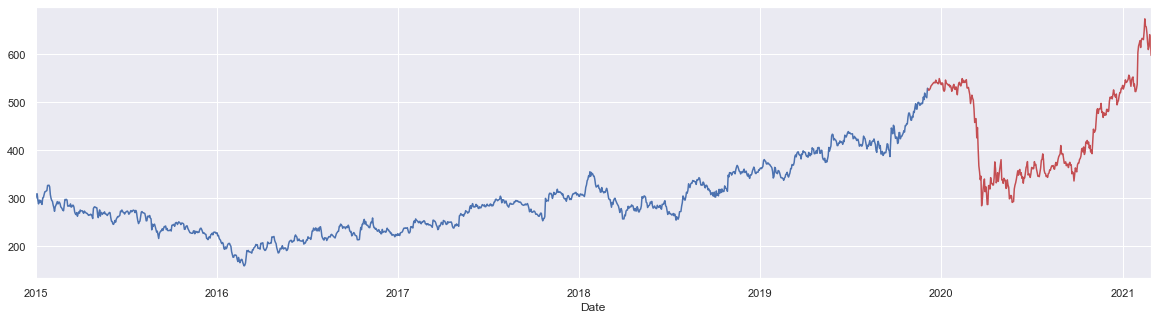

In [146]:
df_train.icici.plot(figsize = (20,5), color="b")
df_test.icici.plot(color="r")

<AxesSubplot:xlabel='Date'>

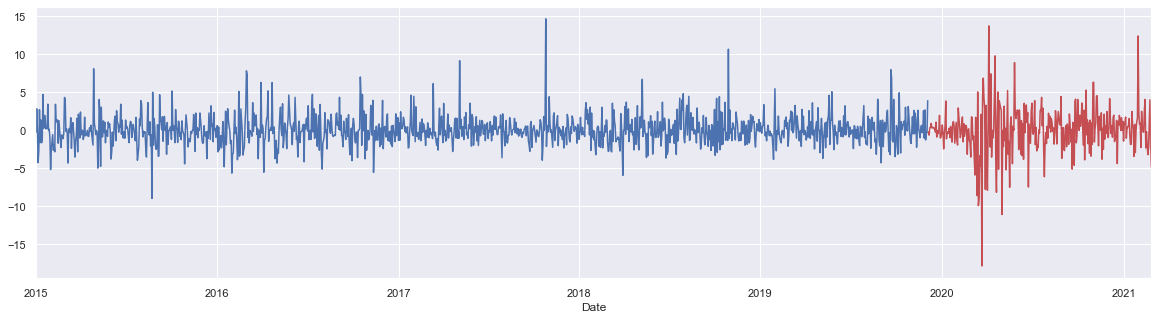

In [147]:
df_train.icici_ret.plot(figsize = (20,5), color="b")
df_test.icici_ret.plot(color="r")

### Testing for Stationarity : Augmented Dickey Fuller Test

In [9]:
sts.adfuller(df.icici)

(-0.5700050875464222,
 0.8776166383573119,
 9,
 1598,
 {'1%': -3.4344487706424953,
  '5%': -2.8633503662338877,
  '10%': -2.567733803393165},
 10859.726996621335)

The ADF statistics is greater than the critical value; Failed to show stationarity with respect to price.

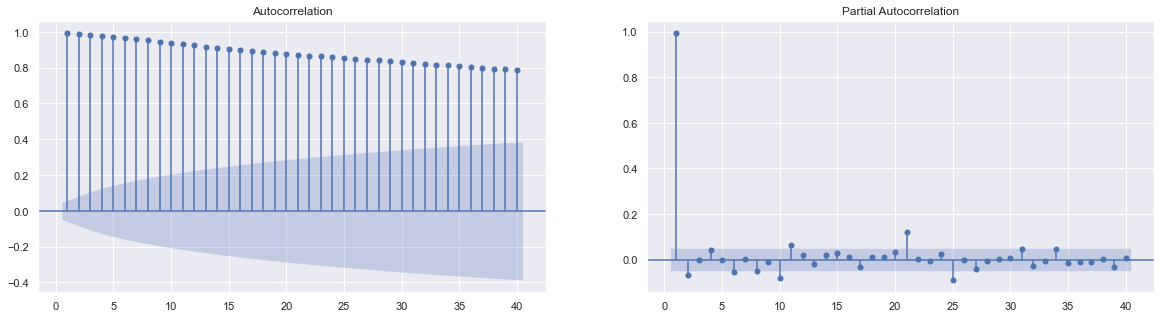

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
sgt.plot_acf(df.icici, lags=40, zero=False, ax=ax1)
sgt.plot_pacf(df.icici,lags=40, zero=False, ax=ax2)
plt.show()

In [11]:
sts.adfuller(df.icici_ret[1:])

(-12.64955412400665,
 1.377883163305409e-23,
 9,
 1597,
 {'1%': -3.434451341329522,
  '5%': -2.863351500889469,
  '10%': -2.567734407591096},
 7004.142302135972)

The ADF statistics is far below the critical value; Stationarity Found. We can use this data for further analysis

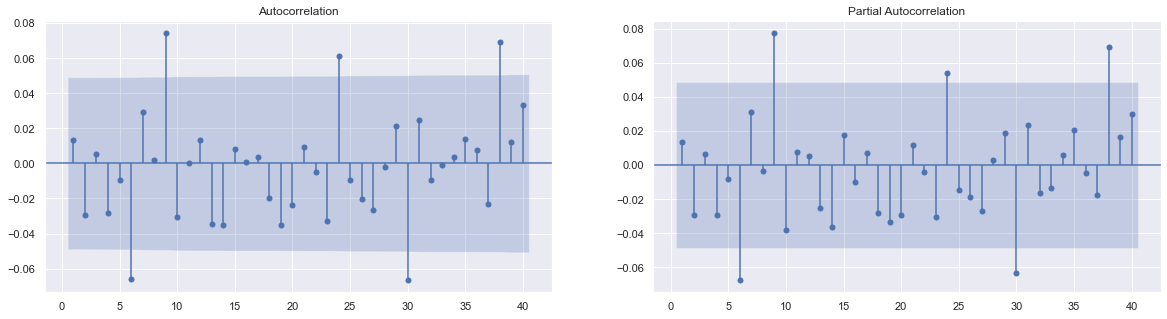

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
sgt.plot_acf(df.icici_ret[1:], lags=40, zero=False, ax=ax1)
sgt.plot_pacf(df.icici_ret[1:],lags=40, zero=False, ax=ax2)
plt.show()

6th and 9th lag is significant in our analysis; we can start our analysis by taking p=6 and q=6.

### Testing for seasonality

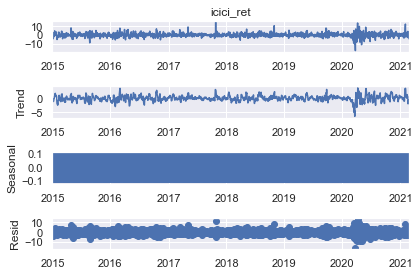

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
season=seasonal_decompose(df.icici_ret[1:], model='additive') 
season.plot()
plt.show()

### Log Likelihood Ratio Test

In [51]:
def LLR_test(mod_1, mod_2, df):
    from scipy.stats import chi2
    l1=mod_1.llf
    l2=mod_2.llf
    p=chi2.sf(2*(l2-l1), df).round(3)
    return p

### Searching for a good model

In [45]:
for p in range(1, 5):
    for q in range(1, 5):
        order=(p,0,q)
        model=ARIMA(df_train.icici_ret[1:],exog=df_train[["bse_ret", "nse_ret", "hdfc_ret"]][1:], order=order)
        results=model.fit()
        if (p==1 & q==1):
            best=(p, q, results.aic)
        print(p, q, results.aic)
        if (results.aic < best[2]):
            best=(p, q, results.aic)
        else:
            continue

1 1 4581.981480468612
1 2 4583.585205424644
1 3 4578.086854292409
1 4 4586.418288504363
2 1 4583.610237870426
2 2 4580.381051468562
2 3 4579.981899888659
2 4 4581.893705360295
3 1 4578.014929960511
3 2 4579.9031990262365
3 3 4581.739135668674
3 4 4581.815287413403
4 1 4580.010397156216
4 2 4581.889602578149
4 3 4581.821651458006
4 4 4577.30928816774


The best model according to the lowest AIC value is ARMA(4, 4)

In [46]:
print(best)

(4, 4, 4577.30928816774)


### Summary Statistics for ARMA(5,3)

In [47]:
arma53 = ARIMA(df_train.icici_ret[1:],exog=df_train[["bse_ret", "nse_ret", "hdfc_ret"]][1:], order=(5,0,3))
result_arma53=arma53.fit()

In [17]:
result_arma53.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              icici_ret   No. Observations:                 1285
Model:                     ARMA(5, 3)   Log Likelihood               -2274.981
Method:                       css-mle   S.D. of innovations              1.421
Date:                Sat, 27 Feb 2021   AIC                           4575.961
Time:                        13:13:14   BIC                           4643.022
Sample:                    01-01-2015   HQIC                          4601.137
                         - 12-04-2019                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0279      0.028      0.991      0.322      -0.027       0.083
bse_ret             2.7031      0.396      6.819      0.000       1.926       3.480
nse_ret            -0.8727      0.391     -2.232      0.026      -1.639      -0.106
hdfc_ret           -0.3598      0.052     -6.896      0.000      -0.462      -0.258
ar.L1.icici_ret    -0.5488      0.086     -6.359      0.000      -0.718      -0.380
ar.L2.icici_ret     0.3301      0.123      2.674      0.008       0.088       0.572
ar.L3.icici_ret     0.8586      0.097      8.860      0.000       0.669       1.049
ar.L4.icici_ret    -0.0426      0.038     -1.131      0.258      -0.116       0.031
ar.L5.icici_ret    -0.0522      0.031     -1.677      0.094      -0.113       0.009
ma.L1.icici_ret     0.5478      0.083      6.631      0.000       0.386       0.710
ma.L2.icici_ret    -0.3294      0.121     -2.726      0.006      -0.566      -0.093
ma.L3.icici_ret    -0.8987      0.082    -10.927      0.000      -1.060      -0.737
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7361           -0.6964j            1.0133           -0.3794
AR.2           -0.7361           +0.6964j            1.0133            0.3794
AR.3            1.1731           -0.0000j            1.1731           -0.0000
AR.4            3.7381           -0.0000j            3.7381           -0.0000
AR.5           -4.2549           -0.0000j            4.2549           -0.5000
MA.1            1.1023           -0.0000j            1.1023           -0.0000
MA.2           -0.7344           -0.6856j            1.0047           -0.3805
MA.3           -0.7344           +0.6856j            1.0047            0.3805
-----------------------------------------------------------------------------
"""

### Summary Statistics for ARMA(4,4)

In [48]:
arma44 = ARIMA(df_train.icici_ret[1:],exog=df_train[["bse_ret", "nse_ret", "hdfc_ret"]][1:], order=(4,0,4))
result_arma44=arma44.fit()

In [49]:
result_arma44.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              icici_ret   No. Observations:                 1285
Model:                     ARMA(4, 4)   Log Likelihood               -2275.655
Method:                       css-mle   S.D. of innovations              1.422
Date:                Sat, 27 Feb 2021   AIC                           4577.309
Time:                        13:27:12   BIC                           4644.370
Sample:                    01-01-2015   HQIC                          4602.485
                         - 12-04-2019                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0283      0.035      0.801      0.423      -0.041       0.098
bse_ret             2.5784      0.397      6.489      0.000       1.800       3.357
nse_ret            -0.7465      0.391     -1.907      0.056      -1.513       0.021
hdfc_ret           -0.3618      0.052     -6.948      0.000      -0.464      -0.260
ar.L1.icici_ret     0.2026      0.126      1.608      0.108      -0.044       0.450
ar.L2.icici_ret     0.8985      0.094      9.586      0.000       0.715       1.082
ar.L3.icici_ret     0.2935      0.065      4.536      0.000       0.167       0.420
ar.L4.icici_ret    -0.8278      0.097     -8.542      0.000      -1.018      -0.638
ma.L1.icici_ret    -0.1982      0.133     -1.486      0.137      -0.460       0.063
ma.L2.icici_ret    -0.9060      0.093     -9.778      0.000      -1.088      -0.724
ma.L3.icici_ret    -0.3446      0.069     -5.021      0.000      -0.479      -0.210
ma.L4.icici_ret     0.8331      0.112      7.422      0.000       0.613       1.053
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8219           -0.6200j            1.0295           -0.3971
AR.2           -0.8219           +0.6200j            1.0295            0.3971
AR.3            0.9992           -0.3759j            1.0676           -0.0573
AR.4            0.9992           +0.3759j            1.0676            0.0573
MA.1           -0.8083           -0.6202j            1.0188           -0.3958
MA.2           -0.8083           +0.6202j            1.0188            0.3958
MA.3            1.0151           -0.3549j            1.0754           -0.0535
MA.4            1.0151           +0.3549j            1.0754            0.0535
-----------------------------------------------------------------------------
"""

### Summary Statistics for ARMA(3,1)

In [56]:
arma31 = ARIMA(df_train.icici_ret[1:],exog=df_train[["bse_ret", "nse_ret", "hdfc_ret"]][1:], order=(3,0,1))
result_arma31=arma31.fit()

In [57]:
result_arma31.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              icici_ret   No. Observations:                 1285
Model:                     ARMA(3, 1)   Log Likelihood               -2280.007
Method:                       css-mle   S.D. of innovations              1.427
Date:                Sat, 27 Feb 2021   AIC                           4578.015
Time:                        13:34:59   BIC                           4624.442
Sample:                    01-01-2015   HQIC                          4595.444
                         - 12-04-2019                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0278      0.028      0.995      0.320      -0.027       0.083
bse_ret             2.5859      0.399      6.487      0.000       1.805       3.367
nse_ret            -0.7630      0.393     -1.944      0.052      -1.532       0.006
hdfc_ret           -0.3529      0.052     -6.784      0.000      -0.455      -0.251
ar.L1.icici_ret     0.9071      0.076     11.858      0.000       0.757       1.057
ar.L2.icici_ret     0.0087      0.038      0.229      0.819      -0.066       0.083
ar.L3.icici_ret    -0.0404      0.031     -1.321      0.187      -0.100       0.020
ma.L1.icici_ret    -0.9135      0.072    -12.711      0.000      -1.054      -0.773
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1588           +0.0000j            1.1588            0.0000
AR.2            4.1759           +0.0000j            4.1759            0.0000
AR.3           -5.1192           +0.0000j            5.1192            0.5000
MA.1            1.0947           +0.0000j            1.0947            0.0000
-----------------------------------------------------------------------------
"""

In [61]:
LLR_test(result_arma31, result_arma44, 4)

0.069

In [62]:
LLR_test(result_arma31, result_arma53, 4)

0.04

### Predicted Returns for Test Set

In [148]:
start_date="2019-12-05"
end_date="2021-01-01" 

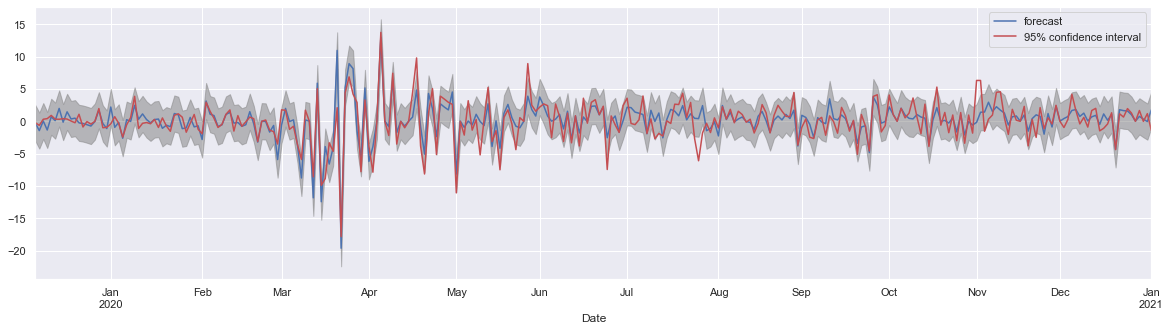

In [141]:
fig, ax= plt.subplots(1,1,figsize=(20,5))
result_arma53.plot_predict(start=start_date, end = end_date, ax=ax, alpha=0.05, dynamic=True, plot_insample=False,
                               exog=df_test[["bse_ret", "nse_ret", "hdfc_ret"]][start_date:end_date])
df_test.icici_ret[start_date:end_date].plot(color='r', label='icici', ax=ax)
plt.show()

### Checking Residuals for Overfitting Case

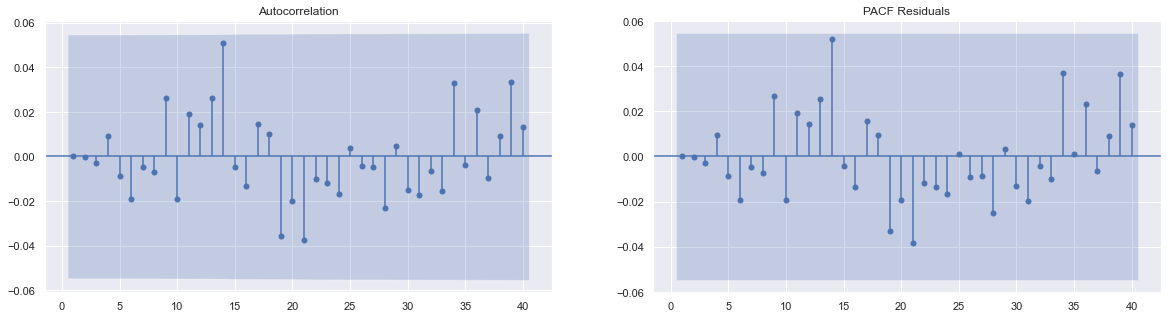

In [63]:
res_53 = result_arma53.resid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
sgt.plot_acf(res_53, lags=40, zero=False, ax=ax1)
plt.title("ACF Residuals")
sgt.plot_pacf(res_53, lags= 40, zero=False, ax=ax2)
plt.title("PACF Residuals")
plt.show()

No Overfitting Found, the 5th and 10th and 14th lags are close to being significant but they are not significant, hence no overfitting.

We have found that ARMA(5,3) is significant over ARMA(3, 1) & ARMA(4,4). Thus, ARMA(5, 3) is preffered.

In [88]:
len(df_test.icici_ret[end_date:])

41

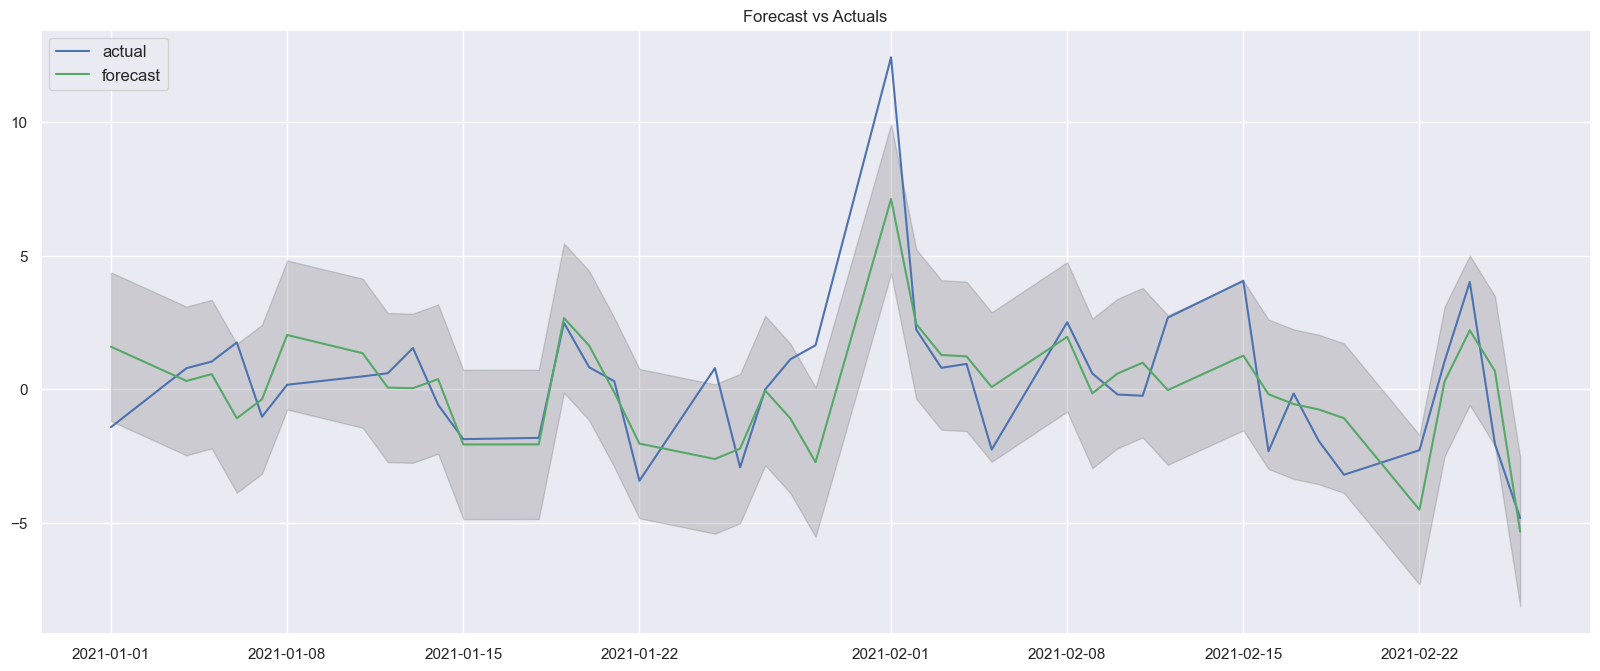

In [101]:
fc, se, conf= result_arma53.forecast(41, alpha=0.05, exog=df_test[["bse_ret", "nse_ret", "hdfc_ret"]][end_date:][:41])
# Make as pandas series
fc_series = pd.Series(fc, index=df_test.icici_ret[end_date:][:41].index)
lower_series = pd.Series(conf[:, 0], index=df_test.icici_ret[end_date:][:41].index)
upper_series = pd.Series(conf[:, 1], index=df_test.icici_ret[end_date:][:41].index)

# Plot
plt.figure(figsize=(20, 8), dpi=100)
#plt.plot(df_train.icici_ret, label='training')
plt.plot(df_test.icici_ret[end_date:][:41], label='actual', color='b')
plt.plot(fc_series, label='forecast', color='g')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()

### Forecasting Volatality

In [35]:
model1 = arch_model(
            df.icici_ret[1:],
            mean="constant",
            vol="GARCH",
            p=1,
            q=1
            )
results1 = model1.fit(last_obs= start_date, update_freq=10)
results1.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2658.296288640122
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              icici_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2658.30
Distribution:                  Normal   AIC:                           5324.59
Method:            Maximum Likelihood   BIC:                           5345.23
                                        No. Observations:                 1285
Date:                Sat, Feb 27 2021   Df Residuals:                     1284
Time:                        13:21:49   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0801  5.333e-02      1.502      0.133 [-2.443e-02,  0.185]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.3910      0.207      1.893  5.837e-02  [-1.386e-02,  0.796]
alpha[1]       0.0429  2.010e-02      2.134  3.281e-02 [3.506e-03,8.228e-02]
beta[1]        0.8526  5.675e-02     15.023  5.162e-51     [  0.741,  0.964]
============================================================================

Covariance estimator: robust
"""

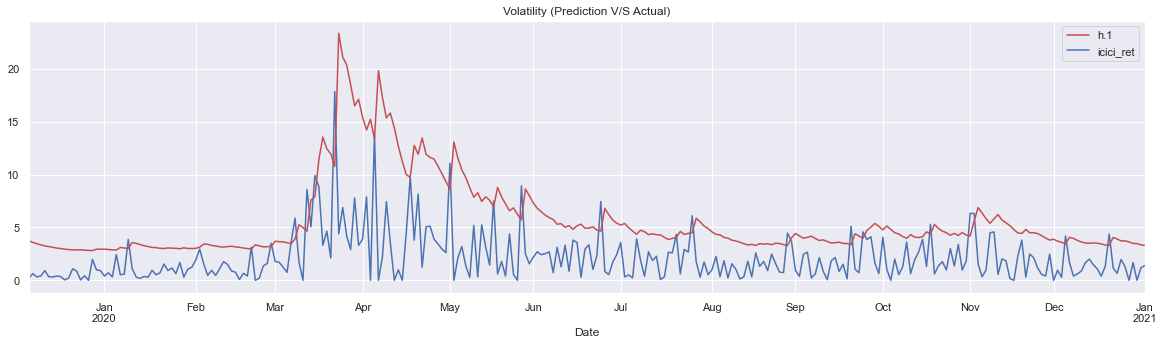

In [165]:
pred_garch = results1.forecast(horizon=1, align="target")
pred_garch.residual_variance[start_date:end_date].plot(figsize=(20,5), zorder=2, color='r')
df_test.icici_ret[start_date:end_date].abs().plot(zorder=1)
plt.title("Volatility (Prediction V/S Actual)")
plt.legend()
plt.show()

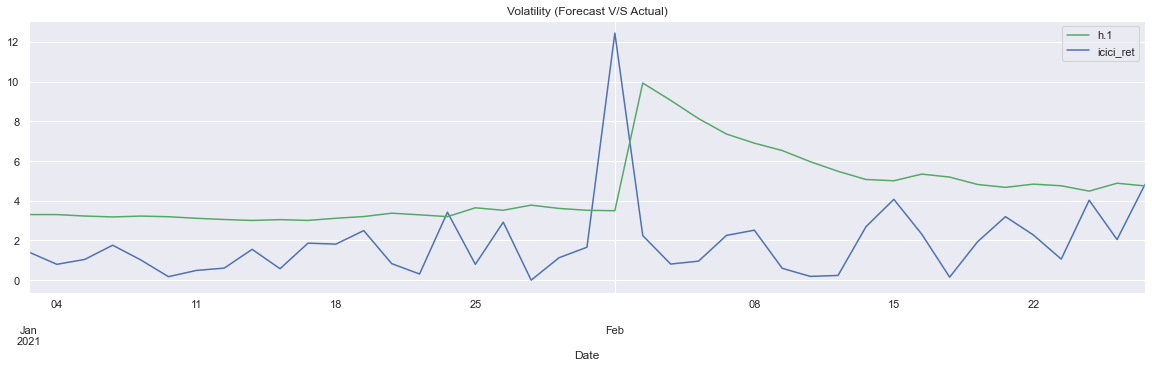

In [167]:
pred_vol=results1.forecast(horizon=1, align="target")
pred_vol.residual_variance[end_date:].plot(figsize=(20,5), zorder=2, color='g')
df_test.icici_ret[end_date:].abs().plot(zorder=1)
plt.title("Volatility (Forecast V/S Actual)")
plt.legend()
plt.show()